In [ ]:
!pip install bilby

In [ ]:
!pip install gwpy

In [ ]:
!pip install lalsuite

08:55 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: __main__.sine_gaussian
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
/usr/local/lib/python3.6/dist-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
08:55 bilby INFO    : Injected signal in H1:
08:55 bilby INFO    :   optimal SNR = 9.83
08:55 bilby INFO    :   matched filter SNR = 8.58-0.91j
08:55 bilby INFO    :   A = 5e-22
08:55 bilby INFO    :   f0 = 50
08:55 bilby INFO    :   tau = 0.02
08:55 bilby INFO    :   phi0 = 0
08:55 bilby INFO    :   geocent_time = 0
08:55 bilby INFO    :   ra = 0
08:55 bilby INFO    :   dec = 0
08:55 bilby INFO    :   psi = 0
08:55 bilby INFO    :   M = 0.02
08:55 bilby INFO    :   y = 0.1
08:55 bilby INFO    : Injected signal in L1:
08:55 bilby INF

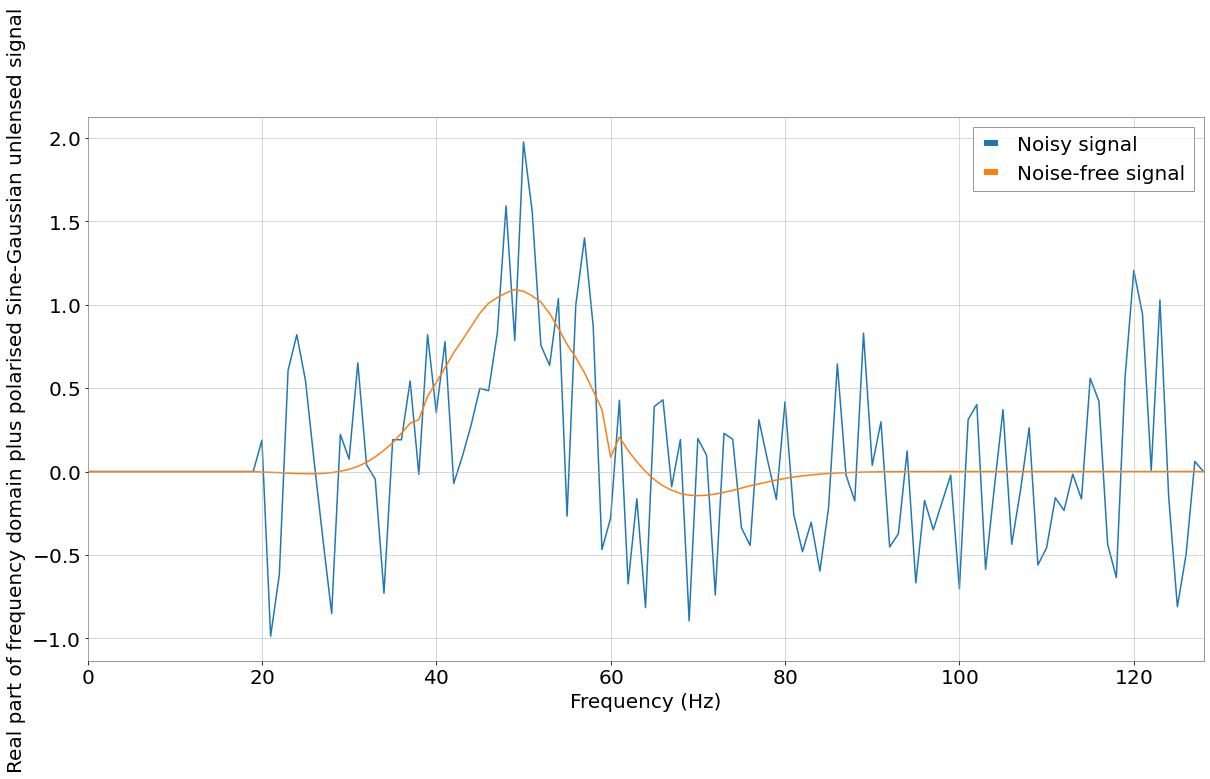

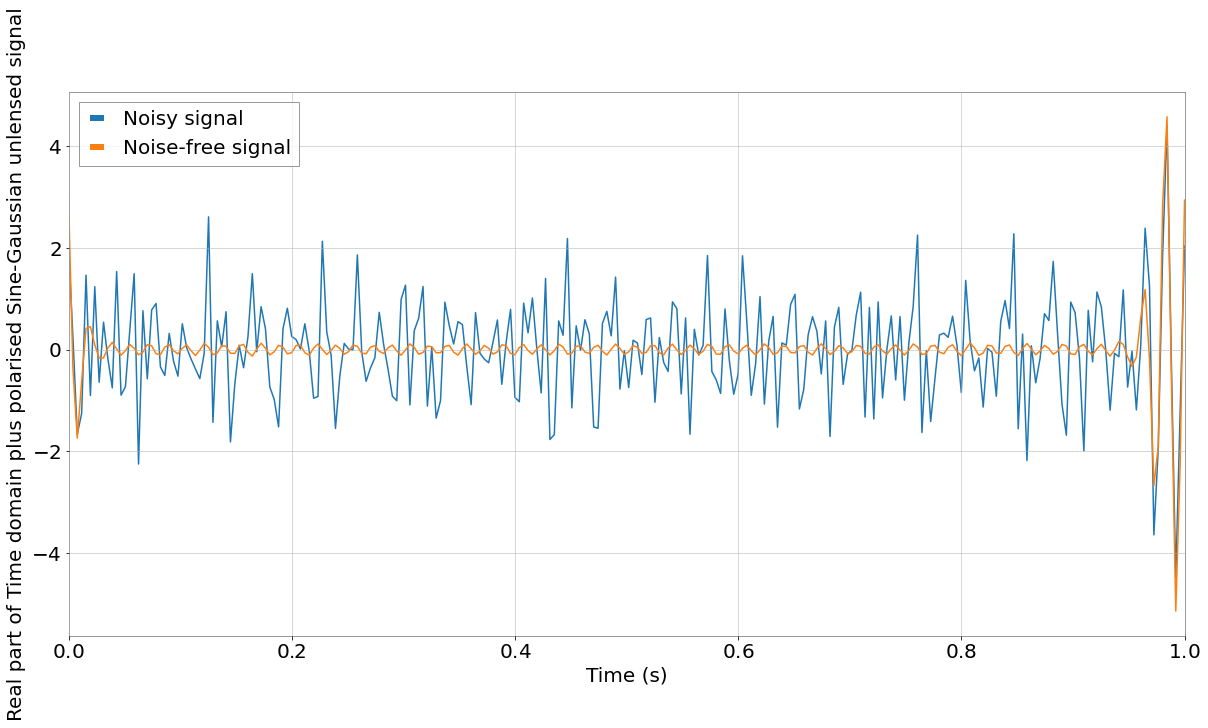

In [ ]:
#!/usr/bin/env python
import matplotlib.pyplot as plt
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
"""
A script to demonstrate how to plot your own source model
"""
from __future__ import division, print_function
import bilby
import numpy as np
import scipy
from scipy.special import hyp1f1
import mpmath as mp
import matplotlib.pyplot as plt

# First set up logging and some output directories and labels
outdir = 'outdir'
label = 'create_your_own_source_model'
sampling_frequency = 256
duration = 1

# Here we define out source model - this is the sine-Gaussian model in the
# frequency domain.
def sine_gaussian(f, A, f0, tau, phi0, geocent_time, ra, dec, psi, M, y):
    w = 8*np.pi*M*f
    arg = -(np.pi * tau * (f - f0))**2 + 1j * phi0 
    plus = np.sqrt(np.pi) * A * tau * np.exp(arg) / 2.
    cross = plus * np.exp(1j * np.pi / 2)
    return {'plus': plus, 'cross': cross}

# We now define some parameters that we will inject
injection_parameters = dict(A=5e-22, f0=50, tau=0.02, phi0=0, geocent_time=0,
                            ra=0, dec=0, psi=0, M=2e-2, y=0.1)

# Now we pass our source function to the WaveformGenerator
waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=sine_gaussian)

# Set up interferometers.
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'])
ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)

# compute the number of time domain samples
Nt = int(sampling_frequency*duration)

# extract waveform from bilby
freq_signal = waveform_generator.frequency_domain_strain() 

# get frequency domain noise-free signal at detector
signal_fd = ifos[0].get_detector_response(freq_signal, injection_parameters)

# whiten frequency domain noise-free signal (and reshape/flatten)
whitened_signal_fd = signal_fd/ifos[0].amplitude_spectral_density_array

# get frequency domain signal + noise at detector
h_fd = ifos[0].strain_data.frequency_domain_strain

# inverse FFT noise-free signal back to time domain and normalise
whitened_signal_td = np.sqrt(2.0*Nt)*np.fft.irfft(whitened_signal_fd)

# whiten noisy frequency domain signal
whitened_h_fd = h_fd/ifos[0].amplitude_spectral_density_array

# inverse FFT noisy signal back to time domain and normalise
whitened_h_td = np.sqrt(2.0*Nt)*np.fft.irfft(whitened_h_fd)
#print(whitened_signal_td)
#print(whitened_signal_fd)

#plot the source signal
x=np.arange(0,129)
t=np.linspace(0,1,256)
plt.figure(figsize=(20,10))
plt.plot(x,whitened_h_fd, label='Noisy signal')
plt.plot(x,whitened_signal_fd, label='Noise-free signal')
plt.xlim(0,128)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Real part of frequency domain plus polarised Sine-Gaussian unlensed signal', fontsize=20)
plt.legend(fontsize=20)
plt.show()
plt.figure(figsize=(20,10))
plt.plot(t,whitened_h_td,label='Noisy signal')
plt.plot(t,whitened_signal_td,label='Noise-free signal')
plt.xlim(0,1)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Real part of Time domain plus polarised Sine-Gaussian unlensed signal', fontsize=20)
plt.legend(fontsize=20)
plt.show()
